In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
import math
import statistics

In [56]:
def perform_eda(df):
    """
    Performs exploratory data analysis on a given file using Pandas.

    Parameters:
    filename (str): The name of the file to read.

    Returns:
    None
    """

    # Get basic information about the data
    print("Data shape:", df.shape)
    print("Data types:\n", df.dtypes)
    
    print(df.head(10))

    # Get summary statistics for the data
    print("Summary statistics:\n", df.describe())

    # Check for missing values
    print("Missing values:\n", df.isnull().sum())

    # Generate histograms of the numeric variables
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    df[numeric_cols].hist(figsize=(10, 10))

    # Generate boxplots of the numeric variables
    df[numeric_cols].boxplot(figsize=(10, 10))

    # Generate a correlation matrix
    corr_matrix = df.corr()
    plt.figure(figsize=(10, 10))
    plt.title("Correlation matrix")
    plt.imshow(corr_matrix, cmap='coolwarm')
    plt.colorbar()
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
    plt.show()

['weekday' 'saturday' 'sunday']
Data shape: (7920, 18)
Data types:
 FID                     int64
mode                    int64
season                 object
route_id               object
route_name             object
direction_id            int64
day_type_id            object
day_type_name          object
time_period_id         object
time_period_name       object
stop_name              object
stop_id                object
total_ons               int64
total_offs              int64
number_service_days     int64
average_ons             int64
average_offs            int64
average_flow            int64
dtype: object
   FID  mode     season route_id  route_name  direction_id  day_type_id  \
0    1     0  Fall 2019    Green  Green Line             0  day_type_01   
1    2     0  Fall 2019    Green  Green Line             0  day_type_01   
2    3     0  Fall 2019    Green  Green Line             0  day_type_01   
3    4     0  Fall 2019    Green  Green Line             0  day_type_01   
4  

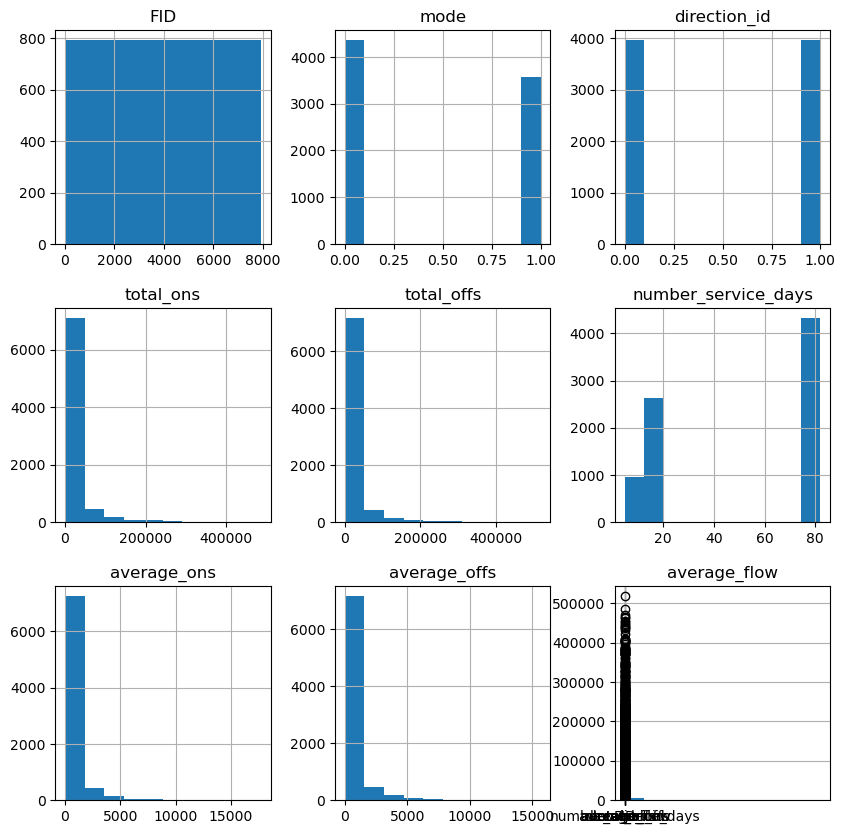

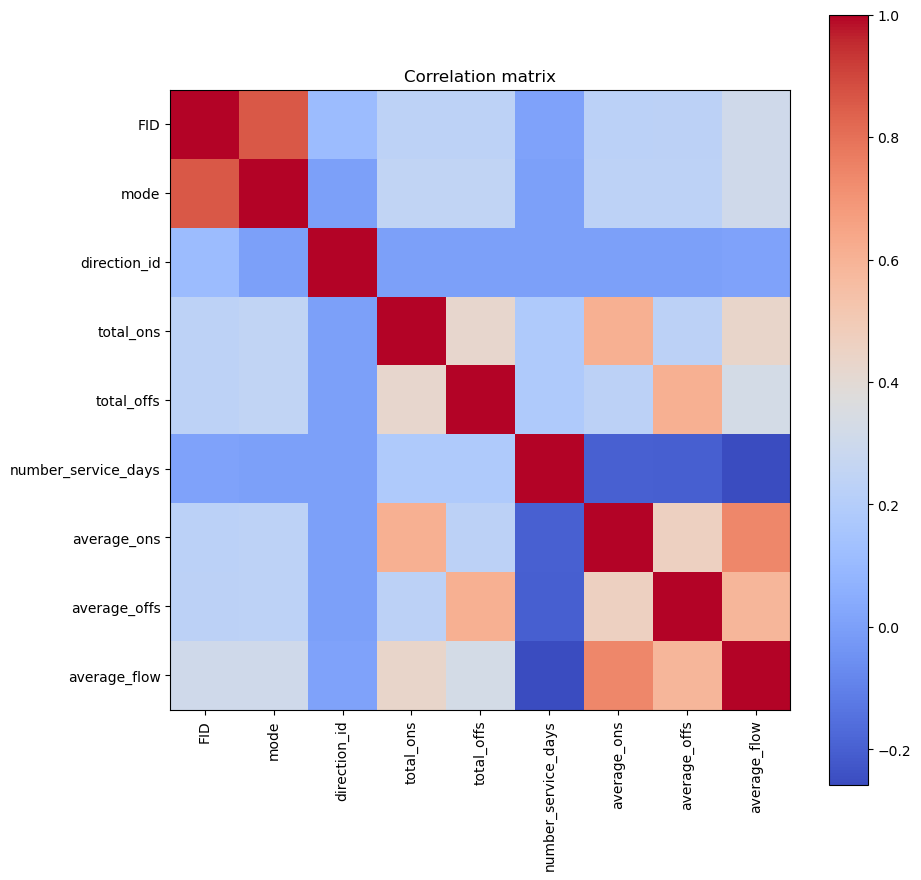

In [57]:
mbta_df = pd.read_csv("MBTA_Line_and_Stop.csv")
print(mbta_df['day_type_name'].unique())
perform_eda(mbta_df)

In [58]:
def add_stop_colors(row):
    if row['stop_name'] == 'Ruggles':
        row['color'] = 'darkorange'
    elif row['stop_name'] == 'Northeastern University':
        row['color'] = 'forestgreen'
    else:
        row['color'] = 'slategrey'
    return row

In [63]:
def add_point_size(row):
    if row['stop_name'] == 'Ruggles':
        row['point_size'] = '90'
    elif row['stop_name'] == 'Northeastern University':
        row['point_size'] = '90'
    else:
        row['point_size'] = '20'
    return row

In [ ]:
def add_stop_colors(row):
    if row['stop_name'] == 'Ruggles':
        row['color'] = 'darkorange'
    elif row['stop_name'] == 'Northeastern University':
        row['color'] = 'forestgreen'
    else:
        row['color'] = 'slategrey'
    return row

In [82]:
#alt.data_transformers.disable_max_rows()
mbta_df = mbta_df.sample(n=5000)

brush = alt.selection_interval()


line = alt.Chart(mbta_df, title='Average # of Passengers Boarding MBTA Stops by Time of Day').mark_line().encode(
    alt.Color('time_period_name', scale=alt.Scale(scheme='category10')),
    x='route_id',
    y='mean(average_ons)',
    #color='time_period_name'
).properties(
    width=500
).add_params(brush).transform_filter(brush)

mbta_df = mbta_df.apply(lambda row: add_stop_colors(row), axis=1)

mbta_df = mbta_df.apply(lambda row: add_point_size(row), axis=1)

domain = mbta_df['color'].unique()
range_ = ['slategrey', 'forestgreen', 'darkorange']


scatter = alt.Chart(mbta_df, title='Average # of Passengers Boarding and Exiting').mark_circle().encode(
    alt.OpacityValue(0.6),
    x='mean(average_ons)',
    y='average_offs',
    tooltip=['stop_name'],
    #color='time_period_name',
    color=alt.Color('color', scale=alt.Scale(domain=domain, range=range_), legend=None),
    size=alt.Size('point_size:N', scale=None)
).properties(
    width=700
).transform_filter(brush).add_params(brush)
scatter & line


alt.VConcatChart(...)

In [81]:
line

alt.Chart(...)

I chose to make the scatter plot because I thought it might be interesting to see if there's any discrepency between the number of passengers boarding and exiting MBTA trains. If those numbers were equal, the scatter plot would show a perfect line with x=y. There was some discrepency, though, which indicates that some MBTA rides are more packed with passengers than others. 

I chose to make the line plot because I wanted to see how busy each MBTA line was throughout the day. It looks like the Green Line was the least busy for all times of day. Additionally, it looks like the off peak was the busiest time of day, which is interesting as I was expecting either morning or evening rush hour to be the busiest. 

I added a pop out effect to the scatter plot. The points representing Ruggle and NU are larger than the other points. Ruggles is orange because it's on the orange line, and NU is green because it's on the green line. 

In [83]:
alt.data_transformers.disable_max_rows()


brush = alt.selection_point()


mbta_line_df = mbta_df.groupby(['route_id', 'time_period_name', 'time_period_id', 'stop_name']
                              ).aggregate({'average_ons': statistics.mean, 
                                           'average_offs': statistics.mean}
                                         ).reset_index()
domain = mbta_line_df['route_id'].unique()
range_ = ['blue', 'green', 'orange', 'red']


color_stops = {}
for color in domain:
    temp_df = mbta_df[mbta_df['route_id'] == color]
    color_stops[color] = list(temp_df['stop_name'].unique())
    
    

mbta_line_df.sort_values('time_period_id', ascending=True, inplace=True, axis=0)


line = alt.Chart(mbta_line_df, title='Average # of Passengers Boarding MBTA Lines Throughout the Day').mark_line().encode(
    x=alt.X('time_period_name:O', sort=list(mbta_line_df['time_period_id'].unique())),
    y='mean(average_ons)',
    color=alt.Color('route_id', scale=alt.Scale(domain=domain, range=range_)),
    #tooltip=['stops'],
).properties(
    width=800,
    height=300
).transform_filter(brush).add_params(brush)
line

alt.Chart(...)